## Low mass diphoton analysis
### Parametric neural network for signal and background classification (step 1):
* **train the model** using a weighted cross entropy loss (or quadratic) function
* **tune the hyperparameters**
* **monitor loss** in training and validation datasets

**SETUP**: Notebook running in [SWAN](https://swan.web.cern.ch/swan) or locally in an anaconda environent. In the second case, you might need to install the needed packages to run the notebook, e.g.:
```
conda install -c conda-forge matplotlib
conda install h5py
conda install -c conda-forge pandas
conda install -c conda-forge uproot
conda install uproot-methods
pip install tensorflow
conda install scikit-learn
```

A dedicated package that includes a set of helpers for matplotlib to more easily produce plots with the classic CMS style is installed ([mphep](https://github.com/scikit-hep/mplhep)):
```
pip install mplhep
```

In [1]:
import numpy as np
import math, os, h5py
import pandas as pd
import ROOT
import uproot

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Layer
import sklearn

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import mplhep as hep

Welcome to JupyROOT 6.28/00


In [2]:
########################################################################
# Inputs: input files and input trees, training variables, mass points #
########################################################################

approach = "nearest_flat"

INPUT_FILE = 'NTUPLES_Apr2024/output_ParaDDFullNorms.root'

# List of signal tree names
tree_names_sig = [
    'ggh_10_13TeV_UntaggedTag_0',
    'ggh_15_13TeV_UntaggedTag_0',
    'ggh_20_13TeV_UntaggedTag_0',
    'ggh_30_13TeV_UntaggedTag_0',
    'ggh_40_13TeV_UntaggedTag_0',
    'ggh_50_13TeV_UntaggedTag_0',
    'ggh_55_13TeV_UntaggedTag_0',
    'ggh_60_13TeV_UntaggedTag_0',
    'ggh_70_13TeV_UntaggedTag_0'
]
    
# List of background tree names
tree_names_bkg = [
    'mgg_bkg_13TeV_UntaggedTag_0',
    'Data_13TeV_UntaggedTag_0'
]

# Lists of variables
vars_list = [
    'dipho_lead_ptoM', 
    'dipho_sublead_ptoM',
    'dipho_leadIDMVA', 
    'dipho_subleadIDMVA',
    'leadEta', 
    'subleadEta',
    'sigmaMrvoM', 
    'sigmaMwvoM',
    'cosphi', 
    'vtxprob',
    'dipho_masshyp_near', 
    'weight'
]

wsig_list = ['w_signal', 'dipho_hypwgt_near', 'dipho_hypnorm_near', 'dipho_hypwgt_near_nowsig'] # Additional weight to flatten ntupels
wbkg_list = ['weight_allDD', 'weight_allDD', 'dipho_hypnorm_near', 'weight_allDD'] # Additional weight to flatten ntupels

In [3]:
# --CREATE A TRAINING DATASET: extract number of events and sum of weights
# ------------------------------------------------------------------------

nEv_sig = []
nEv_bkg = []
nEv_allBkg = []
sum_of_weights_sig = []
sum_of_weights_bkg = []

# Loop to get the sum of weights for signal samples
for tree_name_sig in tree_names_sig:
    file = ROOT.TFile.Open(INPUT_FILE)
    tree = file.Get(f'tagsDumper/trees/{tree_name_sig}')
    print(tree_name_sig)
    rdf_noSel = ROOT.RDataFrame(tree)
    rdf = ROOT.RDataFrame(tree).Filter("candidate_id==0 && dipho_leadIDMVA > -0.7 && dipho_subleadIDMVA > -0.7 && dipho_mass < 75.0 && dipho_lead_prompt==1 && dipho_sublead_prompt ==1")
    nEv_sig.append(rdf.Count().GetValue())
    sum_of_weights_sig.append(rdf.Sum('weight').GetValue())  # Calculate the sum of weights for 'weight' variable
    file.Close()

# Loop to get the sum of weights for background samples
for tree_name_bkg in tree_names_bkg:
    file = ROOT.TFile.Open(INPUT_FILE)
    tree = file.Get(f'tagsDumper/trees/{tree_name_bkg}')
    #rdf = ROOT.RDataFrame(tree)
    if (tree_name_bkg == "mgg_bkg_13TeV_UntaggedTag_0"):
        rdf = ROOT.RDataFrame(tree).Filter("candidate_id==0 && dipho_leadIDMVA > -0.7 && dipho_subleadIDMVA > -0.7 && dipho_mass < 75.0 && processIndex==10")
    else:
        rdf = ROOT.RDataFrame(tree).Filter("candidate_id==0 && dipho_leadIDMVA > -0.7 && dipho_subleadIDMVA > -0.7 && dipho_mass < 75.0 && processIndex==0 && !(dipho_lead_prompt==1 && dipho_sublead_prompt==1)") 
    nEv_bkg.append(rdf.Count().GetValue())
    file.Close()

nEv_allBkg.append(nEv_bkg[0] + nEv_bkg[1])

#################
#    WEIGHTS    #
#################
print("-------------------------------------------------------------")
print("Number of Events in signal trees: ", nEv_sig)
print("Sum of weights in signal trees: ", sum_of_weights_sig)
print("-------------------------------------------------------------")
print("Number of Events in background trees: ", nEv_bkg)
print("Number of ALL Events in background trees: ", nEv_allBkg)
print("-------------------------------------------------------------")

ggh_10_13TeV_UntaggedTag_0
ggh_15_13TeV_UntaggedTag_0
ggh_20_13TeV_UntaggedTag_0
ggh_30_13TeV_UntaggedTag_0
ggh_40_13TeV_UntaggedTag_0
ggh_50_13TeV_UntaggedTag_0
ggh_55_13TeV_UntaggedTag_0
ggh_60_13TeV_UntaggedTag_0
ggh_70_13TeV_UntaggedTag_0
-------------------------------------------------------------
Number of Events in signal trees:  [3840, 6725, 11362, 12902, 14558, 8969, 13498, 18579, 43302]
Sum of weights in signal trees:  [1.9813892114325427, 6.592839548306074, 10.314045458857436, 18.29291252180701, 30.346070407365914, 64.54584455839358, 105.89085759525187, 157.8605439494131, 211.2836018879898]
-------------------------------------------------------------
Number of Events in background trees:  [578281, 1420786]
Number of ALL Events in background trees:  [1999067]
-------------------------------------------------------------


In [4]:
# --CREATE A TRAINING DATASET: open signal and background files and concatenate
# -----------------------------------------------------------------------------

array_sig = []
array_bkg = []

array_sig_w = []
array_bkg_w = []
sig_sumw = []
bkg_sumw = []

################
#    SIGNAL    #
################

# Loop to get the values for each column for signal samples
# ---------------------------------------------------------
for tree_name_sig in tree_names_sig:
    file = ROOT.TFile.Open(INPUT_FILE)
    tree = file.Get(f'tagsDumper/trees/{tree_name_sig}')
    
    # Apply preselection cuts using RDataFrame's Filter
    # -------------------------------------------------
    # TO BLIND: && event % 4 == 0 && Entry$ %1 == 0 
    rdf = ROOT.RDataFrame(tree).Filter("candidate_id==0 && dipho_leadIDMVA > -0.7 && dipho_subleadIDMVA > -0.7 && dipho_mass < 75.0  && dipho_lead_prompt==1 && dipho_sublead_prompt ==1")      
    npdf = rdf.AsNumpy(vars_list)
    array_sig.append(npdf)
    npdf_w = rdf.AsNumpy(wsig_list)
    array_sig_w.append(npdf_w)

sumw_sig = np.repeat(sum_of_weights_sig, nEv_sig)
sumw_sig  = sumw_sig.reshape(-1, 1)

sig_col = [np.hstack([s[var] for s in array_sig]) for var in vars_list]
sig_col_w = [np.hstack([s[var] for s in array_sig_w]) for var in wsig_list]

wsig = np.column_stack(sig_col_w)
sig = np.column_stack(sig_col)

# Create a new column as the product of the last column of sig (12) and the wsig column (13)
# ------------------------------------------------------------------------------------------
#totWeight_sig = sig[:, -1] * wsig[:, -2] * wsig[:, -3] / sumw_sig[:, -1] * 10000
#totWeight_sig = sig[:, -1] * wsig[:, -1] / wsig[:, -3]
#totWeight_sig = sig[:, -1] * wsig[:, -2] * wsig[:, -3] #NEW Without wsig FLAT: wsig[:, -3] is wsig; wsig[:, -2] is norm accounting for wsig
totWeight_sig = sig[:, -1] * wsig[:, -2] * wsig[:, -3] * wsig[:, -4] #NEW With wsig FLAT: wsig[:, -3] is wsig; wsig[:, -2] is norm accounting for wsig
#totWeight_sig = sig[:, -1] * wsig[:, -2] * wsig[:, -3] #NEW With wsig: wsig[:, -3] is wsig; wsig[:, -2] is norm accounting for wsig
#totWeight_sig = sig[:, -1] * wsig[:, -1] #NEW No wsig
totWeight_sig = totWeight_sig.reshape(-1, 1) # Reshape totWeight into a 2D array with a single column

# Create a column of ones with the same number of rows as `sig` and stack it
# --------------------------------------------------------------------------
y_sig = np.ones((sig.shape[0], 1))
sig = np.hstack((sig, totWeight_sig, y_sig))


####################
#    BACKGROUND    #
####################

# Loop to get the values for background samples 
# ---------------------------------------------
for tree_name_bkg in tree_names_bkg:
    file = ROOT.TFile.Open(INPUT_FILE)
    tree = file.Get(f'tagsDumper/trees/{tree_name_bkg}')
    # Apply preselection cuts using RDataFrame's Filter 
    # -------------------------------------------------
    #TO BLIND: && event % 2 != 0 && Entry$ %1 == 0
    if (tree_name_bkg == "mgg_bkg_13TeV_UntaggedTag_0"):
        rdf = ROOT.RDataFrame(tree).Filter("candidate_id==0 && dipho_leadIDMVA > -0.7 && dipho_subleadIDMVA > -0.7 && dipho_mass < 75.0 && processIndex==10 && dipho_masshyp_near < 75.0")
        #rdf = ROOT.RDataFrame(tree).Filter("candidate_id==0 && dipho_leadIDMVA > -0.7 && dipho_subleadIDMVA > -0.7 && dipho_lead_ptoM > 0.47 && dipho_sublead_ptoM > 0.28 && dipho_mass < 75.0 && processIndex==10 && dipho_masshyp_near < 75.0")
    else:
        rdf = ROOT.RDataFrame(tree).Filter("candidate_id==0 && dipho_leadIDMVA > -0.7 && dipho_subleadIDMVA > -0.7 && dipho_mass < 75.0 && processIndex==0 && !(dipho_lead_prompt==1 && dipho_sublead_prompt==1) && dipho_masshyp_near < 75.0")     
        #rdf = ROOT.RDataFrame(tree).Filter("candidate_id==0 && dipho_leadIDMVA > -0.7 && dipho_subleadIDMVA > -0.7 && dipho_lead_ptoM > 0.47 && dipho_sublead_ptoM > 0.28 && dipho_mass < 75.0 && processIndex==0 && !(dipho_lead_prompt==1 && dipho_sublead_prompt==1) && dipho_masshyp_near < 75.0")     
    npdf = rdf.AsNumpy(vars_list)
    array_bkg.append(npdf)
    npdf_w = rdf.AsNumpy(wbkg_list)
    array_bkg_w.append(npdf_w)

bkg_col = [np.hstack([b[var] for b in array_bkg]) for var in vars_list]
bkg_col_w = [np.hstack([b[var] for b in array_bkg_w]) for var in wbkg_list]

wbkg = np.column_stack(bkg_col_w)
bkg = np.column_stack(bkg_col)

defTimesdd_wbkg = bkg[:, -1] * wbkg[:, -1] 
defTimesdd_wbkg = defTimesdd_wbkg.reshape(-1, 1)
sum_of_weights_bkg.append(np.sum(defTimesdd_wbkg))

sumw_bkg = np.repeat(sum_of_weights_bkg[0], nEv_allBkg)
sumw_bkg  = sumw_bkg.reshape(-1, 1)
print("bkg,  wbkg, sumw_bkg shapes = ", bkg.shape, wbkg.shape, sumw_bkg.shape)

# Create a new column as the product of the last column of sig (12) and the wsig column (13)
# ------------------------------------------------------------------------------------------
totWeight_bkg = bkg[:, -1] * wbkg[:, -1]* wbkg[:, -2]  # FLAT DD reweighting  
#totWeight_bkg = bkg[:, -1] * wbkg[:, -1]  # DD reweighting  

totWeight_bkg = totWeight_bkg.reshape(-1, 1) # Reshape totWeight into a 2D array with a single column

# Create a column of zeros with the same number of rows as `bkg` and stack it
# ---------------------------------------------------------------------------
y_bkg = np.zeros((bkg.shape[0], 1))
bkg = np.hstack((bkg, totWeight_bkg, y_bkg))
#bkg = np.hstack((bkg, wbkg, sumw_bkg, totWeight_bkg, y_bkg))


####################################################################    
# --CONCATENATE SIGNAL AND BACKGROUND ARRAYS AND SHUFFLE if needed #
#################################################################### 
training_data = np.concatenate((bkg, sig), axis=0)
#print("Signal shape:", sig.shape)
#print("Background shape:", bkg.shape)
#print(training_data)
print("Training data set shape: ", training_data.shape)

# --Shuffle can be done for a dataset or directly during the training
np.random.shuffle(training_data)

true_label = training_data[:, -2:]
print("true_label.shape", true_label.shape)
print("true_label[:, -1]", true_label[:, -1])
print("true_label[:, -2]", true_label[:, -2])
                    
training_data = training_data[:, :-3]
print("Training data set shape (removing weights and label columns): ", training_data.shape)
print("-----------------------------------------------------------------------------------")

bkg,  wbkg, sumw_bkg shapes =  (1999067, 12) (1999067, 4) (1999067, 1)
Training data set shape:  (2132802, 14)
true_label.shape (2132802, 2)
true_label[:, -1] [0. 0. 0. ... 0. 0. 0.]
true_label[:, -2] [0.16462021 0.16422282 0.04612483 ... 0.03329371 0.26523596 0.05718566]
Training data set shape (removing weights and label columns):  (2132802, 11)
-----------------------------------------------------------------------------------


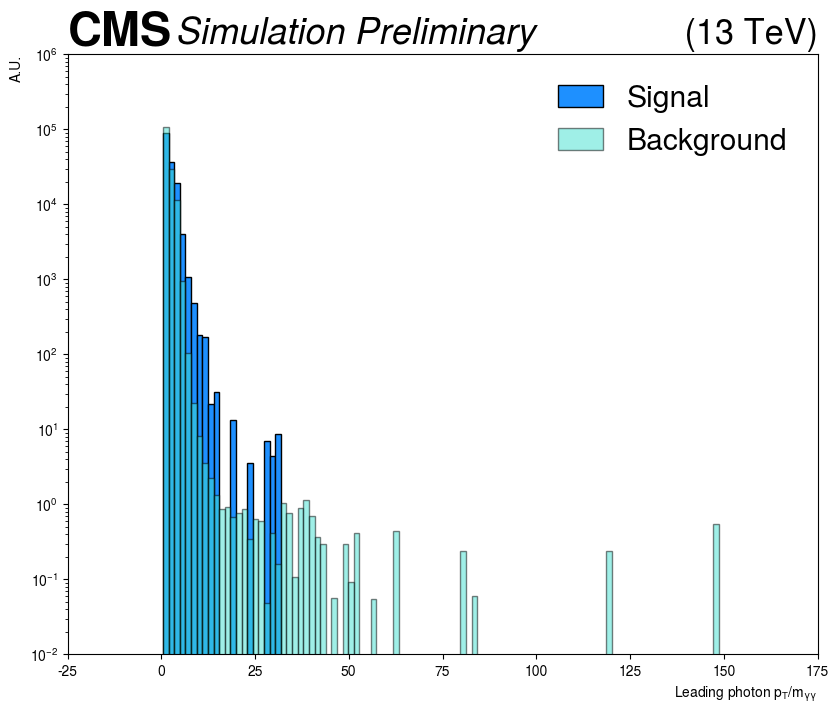

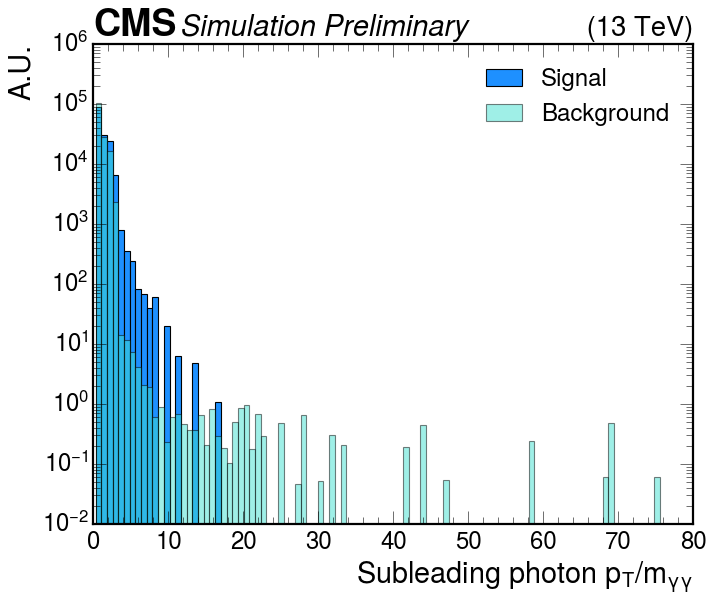

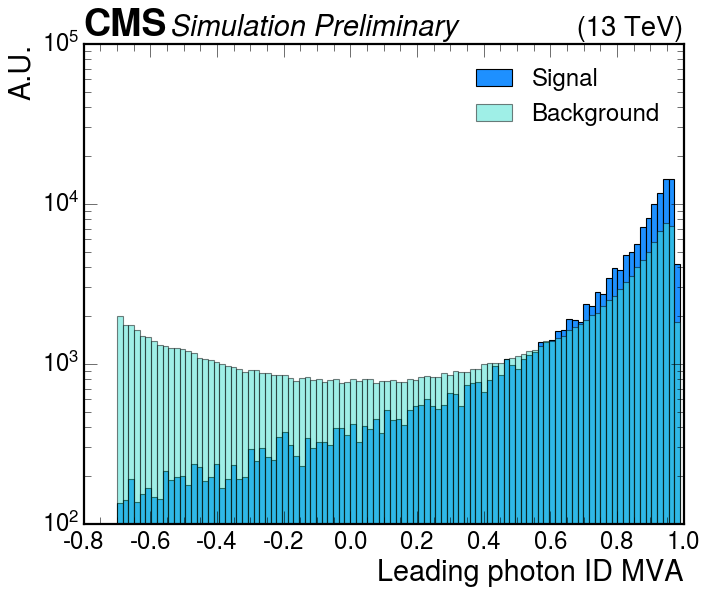

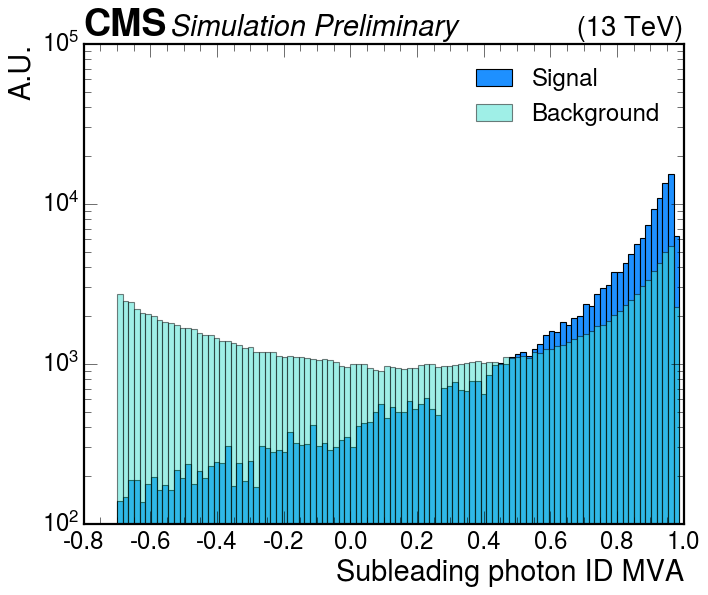

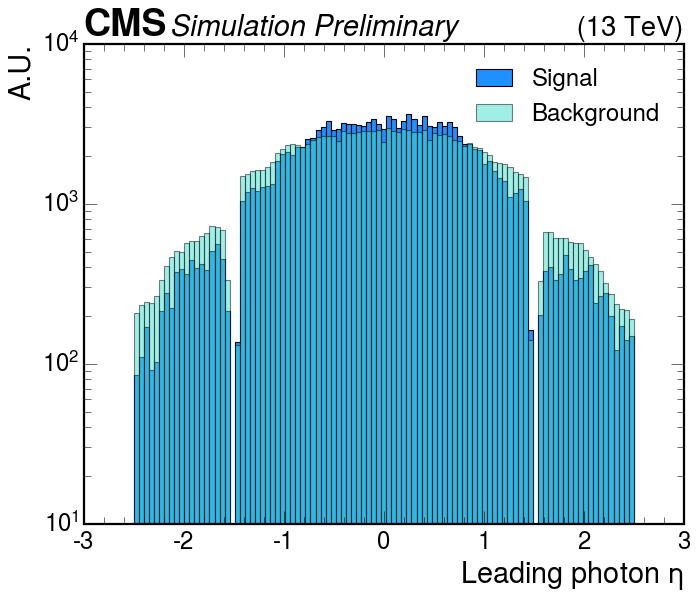

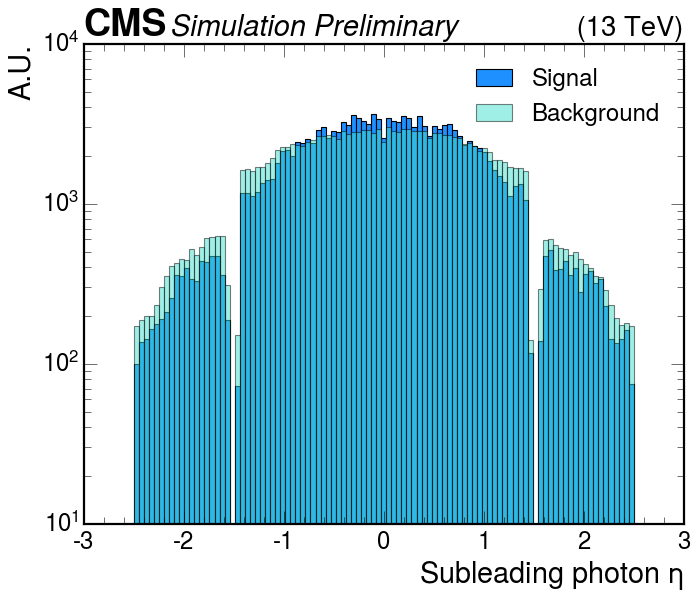

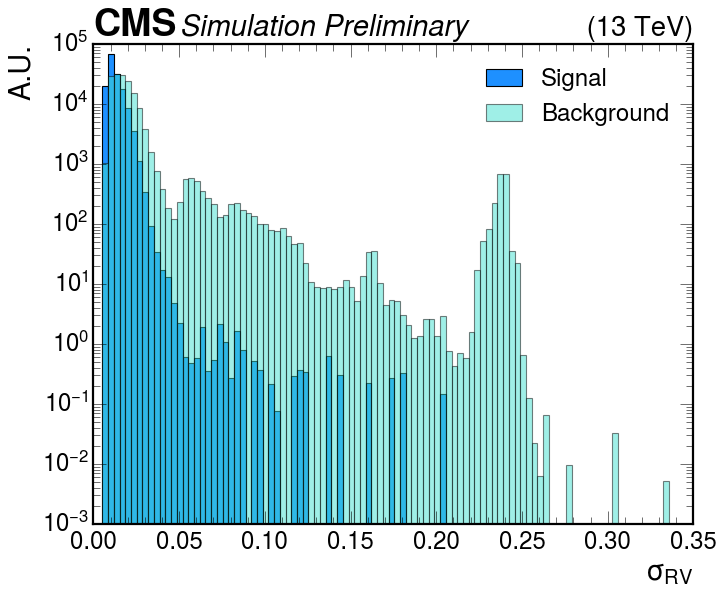

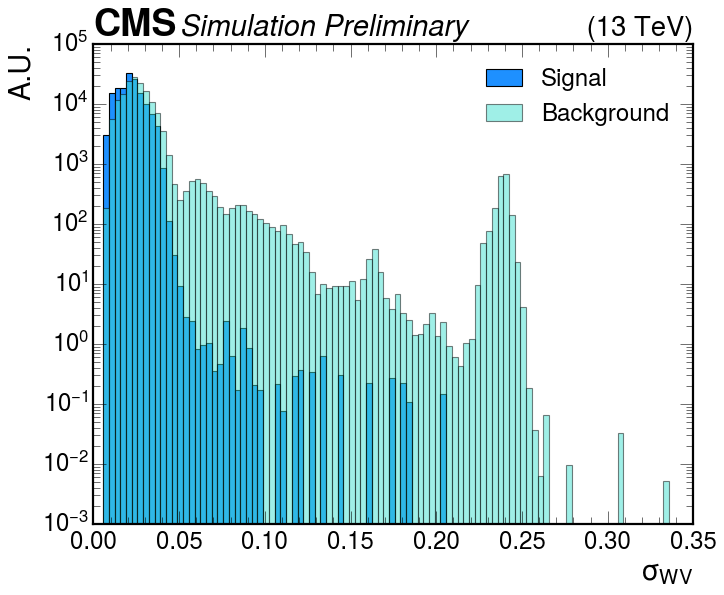

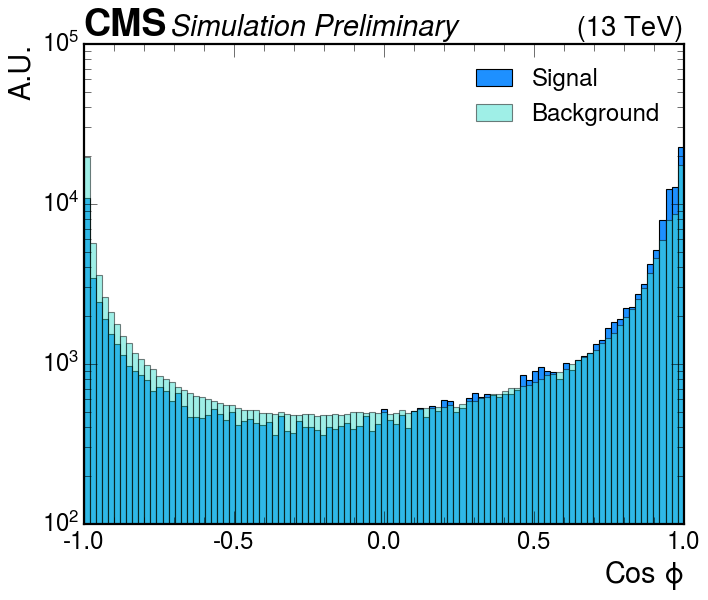

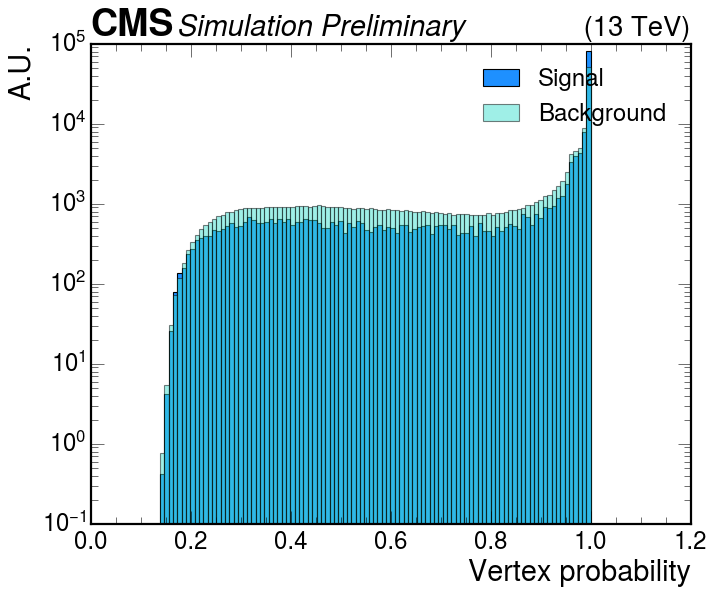

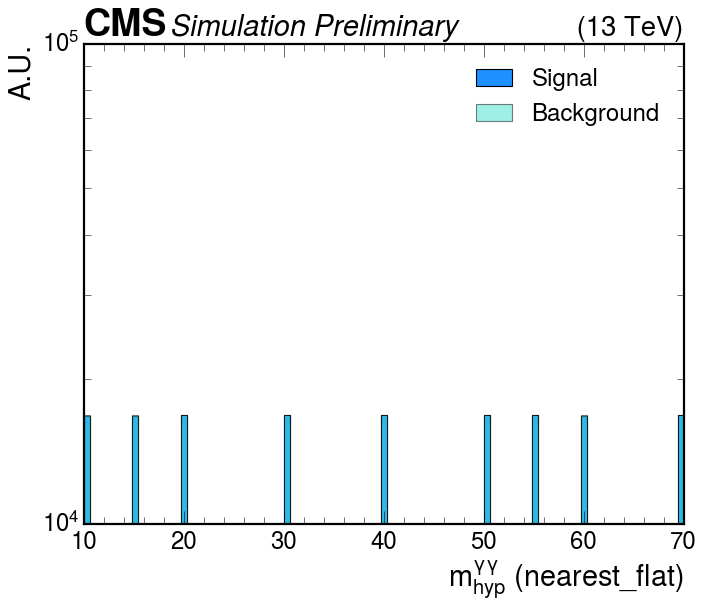

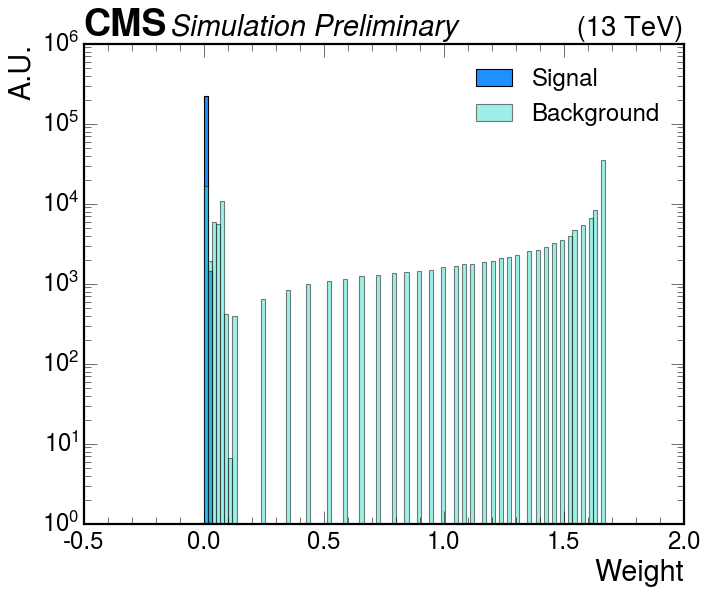

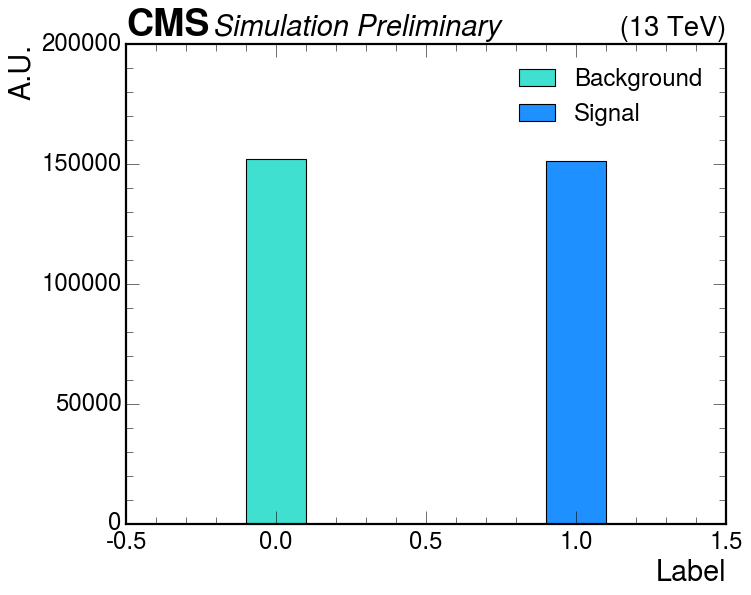

In [5]:
# --CHECKING ALL DISTRIBUTIONS FOR SIGNAL AND BACKGROUND
# ------------------------------------------------------

outdir = "Plots/"+approach+"/inputVars"
num_columns_sig = sig.shape[1]

vars_label_list = [
    'Leading photon $p_{T}/m_{\\gamma\\gamma}$', 'Subleading photon $p_{T}/m_{\\gamma\\gamma}$',
    'Leading photon ID MVA', 
    'Subleading photon ID MVA',
    'Leading photon $\\eta$', 
    'Subleading photon $\\eta$',
    '$\\sigma_{RV}$', 
    '$\\sigma_{WV}$',
    'Cos $\\phi$', 'Vertex probability',
    '$m_{hyp}^{\\gamma\\gamma}$ ('+approach+')', 
    'Weight'
]

# Plot distributions for each column in the signal dataset
# --------------------------------------------------------
for col_index in range(num_columns_sig):
    #print(col_index)

    if (col_index == (len(range(num_columns_sig))-1)):
        fig  = plt.figure(figsize=(10, 8))
        fig.patch.set_facecolor('white')
        ax= fig.add_axes([0.15, 0.15, 0.75, 0.75])
        plt.rcParams["font.family"] = "serif"
        plt.style.use('classic')
        plt.style.use(hep.style.ROOT)
        hep.cms.label("Preliminary", data=False)
        #hep.cms.label("Simulation Preliminary", data=False, lumi=96.6)
        plt.xlabel("Label")
        plt.hist(bkg[:, 13], bins=5, alpha=1.0, label='Background', color='turquoise', weights=bkg[:,-2])
        plt.hist(sig[:, 13], bins=5, alpha=1.0, label='Signal', color='dodgerblue', weights=sig[:,-2])
        plt.ylim(0, 200000)  # Set y-axis limits
        plt.ylabel('A.U.')
        plt.title('')
        plt.legend()
        plt.savefig(outdir+'/label.png')
    elif (col_index < (len(range(num_columns_sig))-2)):
        fig  = plt.figure(figsize=(10, 8))
        fig.patch.set_facecolor('white')
        ax= fig.add_axes([0.15, 0.15, 0.75, 0.75])
        plt.rcParams["font.family"] = "serif"
        plt.style.use('classic')
        plt.style.use(hep.style.ROOT)
        hep.cms.label("Preliminary", data=False)
        #hep.cms.label("Simulation Preliminary", data=False, lumi=96.6)
        bins = np.linspace(np.min(bkg[:, col_index]), np.max(bkg[:, col_index]), 100)
        plt.hist(sig[:, col_index], bins, alpha=1.0, label='Signal', color='dodgerblue', weights=sig[:,-2])
        plt.hist(bkg[:, col_index], bins, alpha=0.5, label='Background', color='turquoise', weights=bkg[:,-2])
        plt.xlabel(vars_label_list[col_index])
        plt.ylabel('A.U.')
        plt.title('')
        plt.yscale('log')  # Set y-axis to logarithmic scale
        plt.legend()
        plt.savefig(outdir+'/'+vars_list[col_index]+".png")
        #plt.show()

In [6]:
####################################
# --STANDARDIZING VARIABLES RANGES #
####################################
mean_REF, std_REF = np.mean(training_data, axis=0), np.std(training_data, axis=0)
for j in range(training_data.shape[1]):
    training_data[:, j] = (training_data[:, j]-mean_REF[j])/std_REF[j]
    
print("mean_REF:")
print(mean_REF)
print("std_REF:")
print(std_REF)

mean_REF:
[ 1.02723945e+00  5.97155929e-01  3.27149360e-01  1.40618341e-01
  1.30073259e-03  1.84589661e-03  2.26421862e-02  2.87247697e-02
 -2.43791035e-01  7.45146274e-01  5.09008220e+01]
std_REF:
[ 0.85487014  0.444752    0.5892425   0.59489149  0.99642843  0.95968482
  0.02581517  0.02511732  0.77730978  0.26923345 16.86734849]


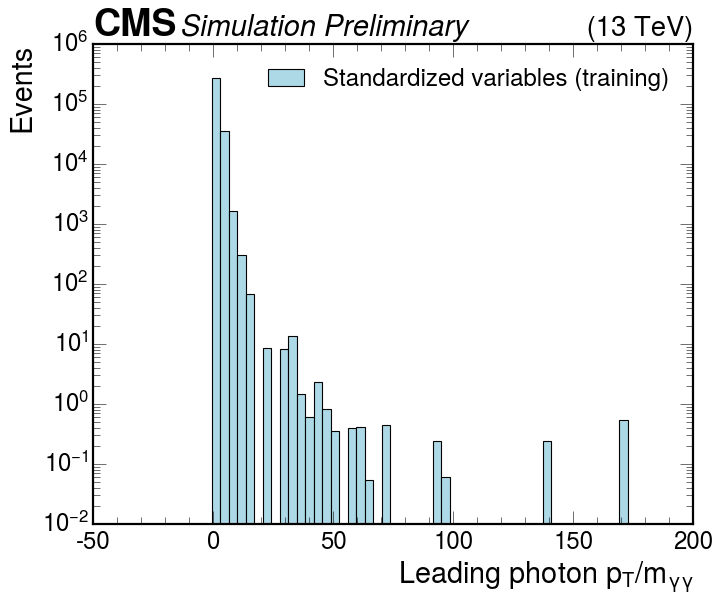

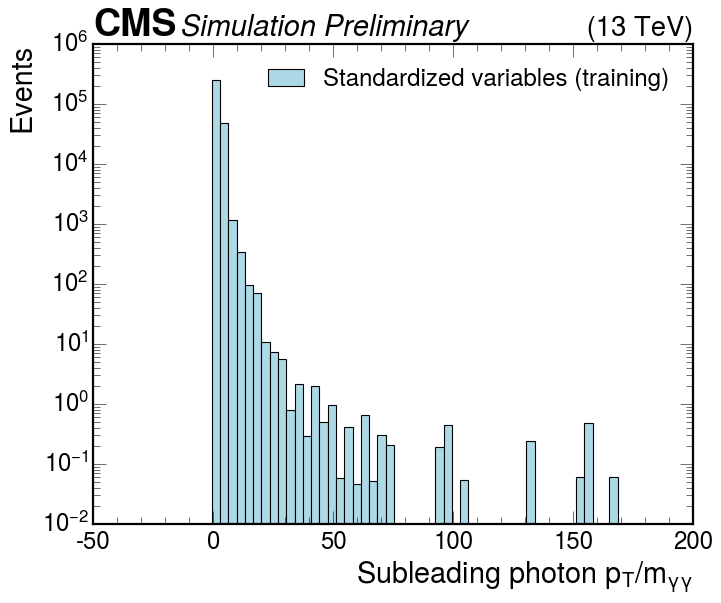

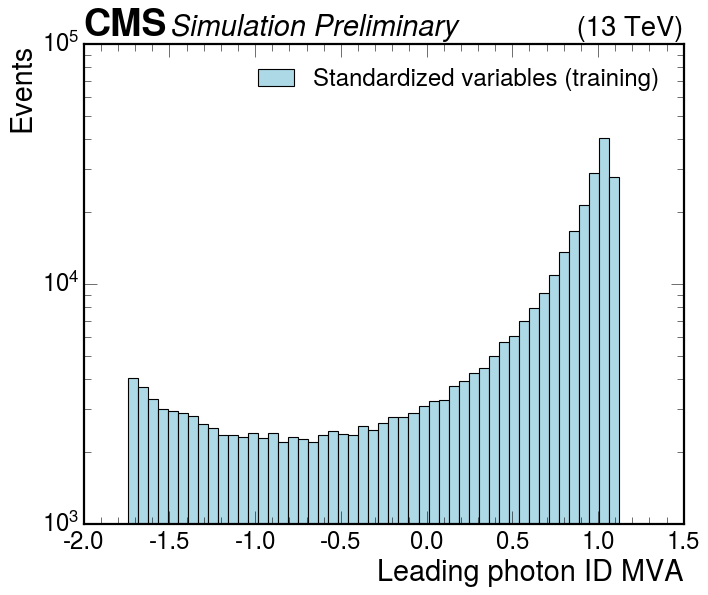

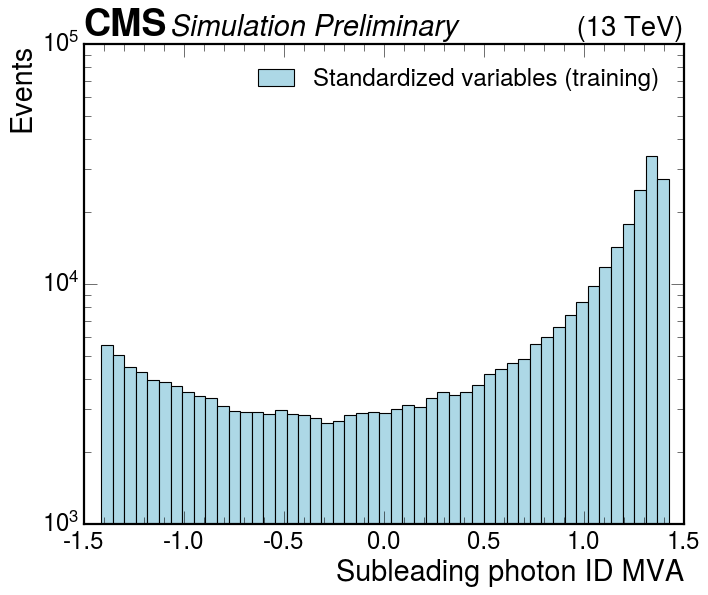

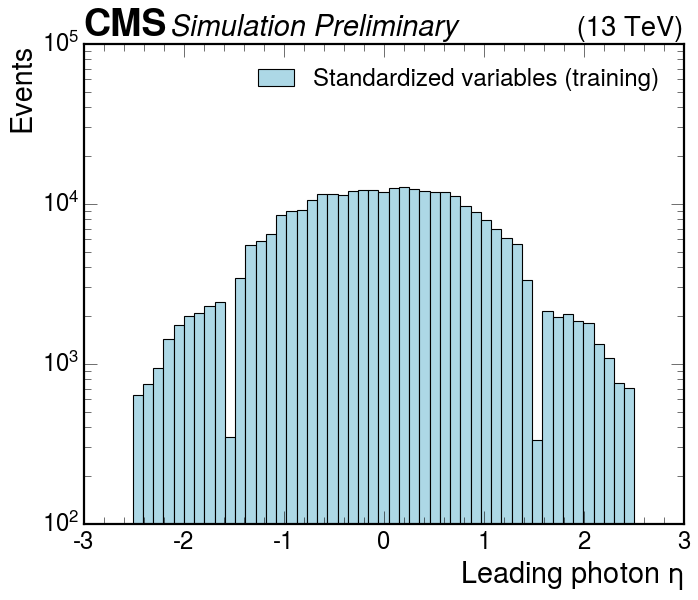

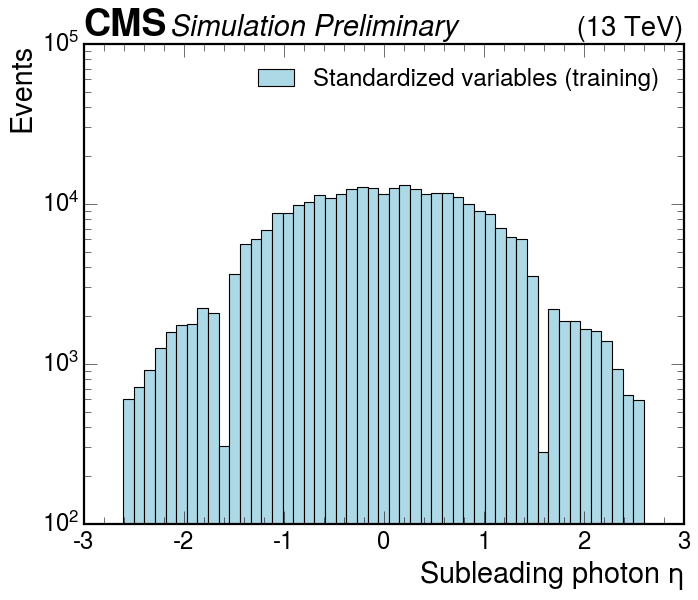

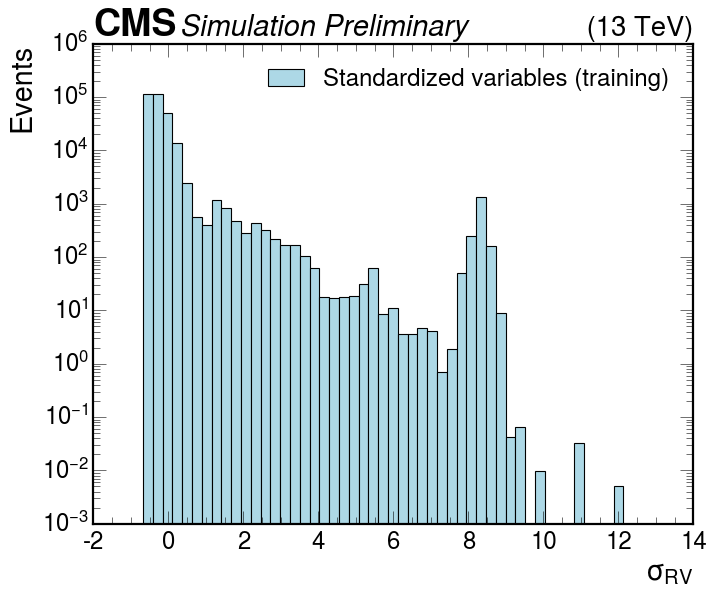

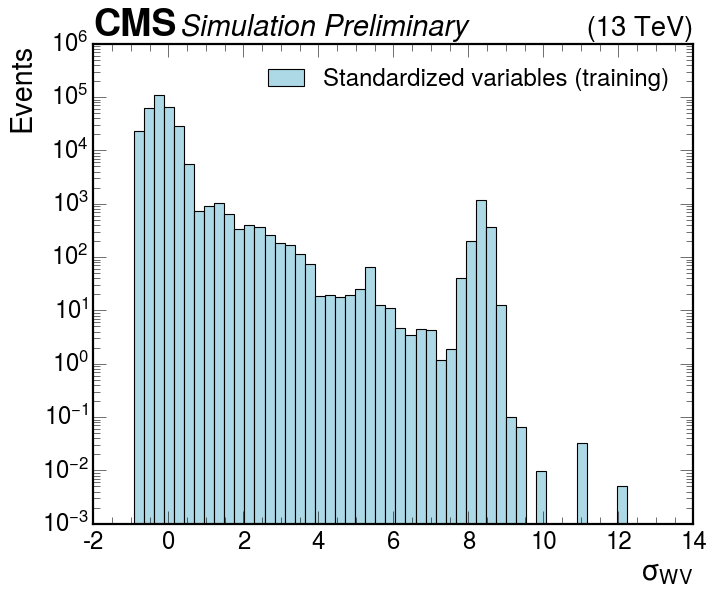

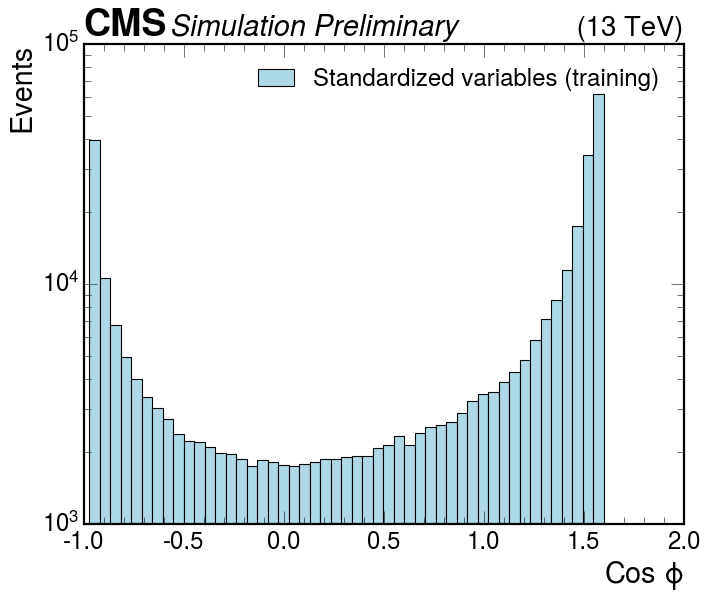

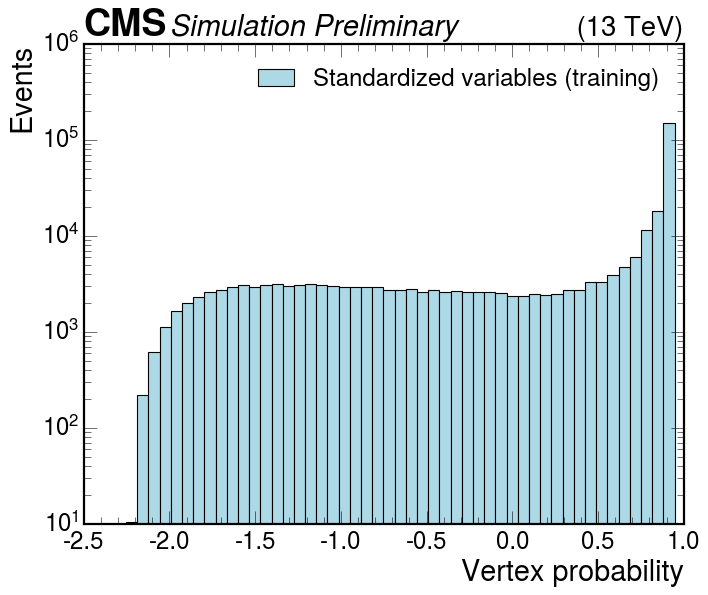

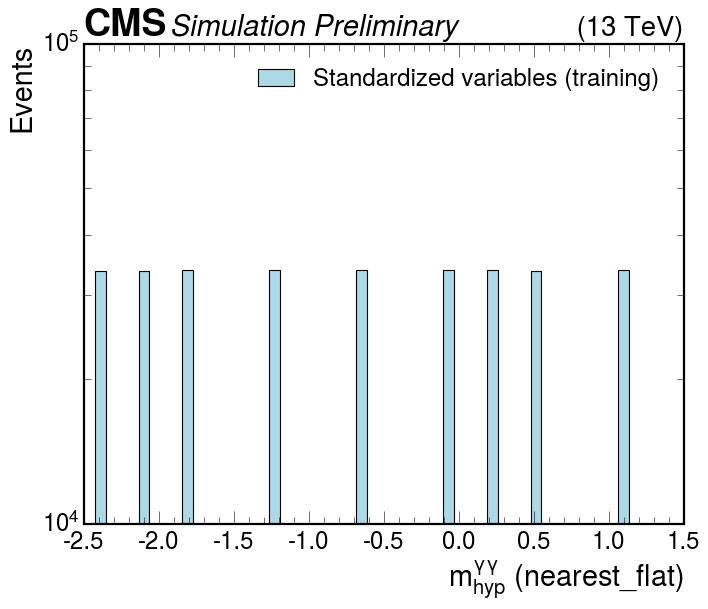

In [7]:
# --CHECKING ALL DISTRIBUTIONS after standardization
# --------------------------------------------------

for col_index in range(num_columns_sig-3):
    #print(col_index)
    fig  = plt.figure(figsize=(10, 8))
    fig.patch.set_facecolor('white')
    ax= fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    plt.style.use(hep.style.ROOT)
    # Overall - both left and right annotation
    hep.cms.label("Preliminary", data=False)
    bins = np.linspace(np.min(training_data[:, col_index]), np.max(training_data[:, col_index]), 50)
    plt.hist(training_data[:, col_index], bins, alpha=1., label='Standardized variables (training)', color='lightblue', weights=true_label[:,0])
    plt.xlabel(vars_label_list[col_index])
    plt.ylabel('Events')
    plt.yscale('log') 

    plt.legend()    
    #plt.show()
    plt.savefig(outdir+'/standardized_'+vars_list[col_index]+".png")

In [8]:
class ParametricClassifier(Model):
    def __init__(self, input_shape, architecture=[1, 4, 1], activation='relu', name=None, **kwargs):
    #def __init__(self, input_shape, architecture=[1, 4, 1], activation='relu', name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        kernel_constraint = None
        self.hidden_layers = [Dense(architecture[i+1], input_shape=(architecture[i],), activation=activation) for i in range(len(architecture)-2)]
        self.output_layer  = Dense(architecture[-1], input_shape=(architecture[-2],), activation='linear')
        #self.output_layer  = Dense(architecture[-1], input_shape=(architecture[-2],), activation='sigmoid')
        self.build(input_shape)
        
    def call(self, x):
        for i, hidden_layer in enumerate(self.hidden_layers):
            x = hidden_layer(x)
        x = self.output_layer(x)
        return x

def QuadraticLoss(true, pred):
    y = true[:, 1] #taken from the true_label definition 
    w = true[:, 0] #taken from the true_label definition 
    f = pred[:, 0]
    c = 1./(1+tf.exp(f))
    return tf.reduce_mean(y*w*c**2 + (1-y)*w*(1-c)**2)

# Same loss function as MLikelihood   
def WeightedCrossEntropyLoss(true, pred):
    y   = true[:, 1] #taken from the true_label definition 
    w   = true[:, 0] #taken from the true_label definition
    f   = pred[:, 0]
    #return 1000*tf.reduce_sum(-(1-y)*w*tf.math.log(1-f) - y*w*tf.math.log(f)) #activation='sigmoid'
    #return tf.reduce_sum((1-y)*w*tf.math.log(1+tf.exp(f)) + y*w*tf.math.log(1+tf.exp(-1*f))) #activation='linear'
    return 0.1*tf.reduce_sum((1-y)*w*tf.math.log(1+tf.exp(f)) + y*w*tf.math.log(1+tf.exp(-1*f))) #activation='linear'
    # Sigmoid transformation applied here

In [9]:
architecture = [11, 50, 50, 50, 1] # f(x, m) = NN(x, {w}, {b}) || f(x, m) = m * NN(x, {w}, {b})
#architecture = [11, 100, 100, 100, 1] # f(x, m) = NN(x, {w}, {b}) || f(x, m) = m * NN(x, {w}, {b})
model = ParametricClassifier(input_shape=(None, 11), architecture=architecture, activation='relu')
#architecture = [9, 100, 100, 100, 1] # f(x, m) = NN(x, {w}, {b}) || f(x, m) = m * NN(x, {w}, {b})
#model = ParametricClassifier(input_shape=(None, 9), architecture=architecture, activation='relu')
optimizer = tf.keras.optimizers.legacy.Adam()

print(model.summary())

Model: "parametric_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  600       
                                                                 
 dense_1 (Dense)             multiple                  2550      
                                                                 
 dense_2 (Dense)             multiple                  2550      
                                                                 
 dense_3 (Dense)             multiple                  51        
                                                                 
Total params: 5751 (22.46 KB)
Trainable params: 5751 (22.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [10]:
model.compile(loss=WeightedCrossEntropyLoss, #QuadraticLoss 
              optimizer=optimizer, 
              metrics=['accuracy'] #metrics=['binary_accuracy']
             )
print(training_data.shape[0])

2132802


In [11]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,  # Change this value to the desired number of epochs without improvement
    restore_best_weights=True,
    start_from_epoch=0
)

#hist = model.fit(training_data, batch_size=10000, epochs=200, verbose=True)
hist = model.fit(training_data, true_label, validation_split=0.5, 
                 #shuffle=True,
                 #validation_data=(val_data, val_label), 
                 batch_size=training_data.shape[0], 
                 epochs=200, 
                 callbacks=early_stopping_callback,
                 verbose=True)

Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 10649.0693 - accuracy: 0.4667 - val_loss: 10414.8721 - val_accuracy: 0.4674
Epoch 2/200
1/1 [==============================] - 0s 396ms/step - loss: 10508.7402 - accuracy: 0.4675 - val_loss: 10294.5156 - val_accuracy: 0.4679
Epoch 3/200
1/1 [==============================] - 0s 369ms/step - loss: 10379.4805 - accuracy: 0.4679 - val_loss: 10181.8076 - val_accuracy: 0.4681
Epoch 4/200
1/1 [==============================] - 0s 391ms/step - loss: 10259.0039 - accuracy: 0.4681 - val_loss: 10074.6221 - val_accuracy: 0.4682
Epoch 5/200
1/1 [==============================] - 0s 386ms/step - loss: 10145.2178 - accuracy: 0.4682 - val_loss: 9971.3408 - val_accuracy: 0.4680
Epoch 6/200
1/1 [==============================] - 0s 388ms/step - loss: 10036.3936 - accuracy: 0.4681 - val_loss: 9870.8906 - val_accuracy: 0.4675
Epoch 7/200
1/1 [==============================] - 0s 384ms/step - loss: 9931.3359 - accuracy: 0.4675 - val_los

1/1 [==============================] - 0s 437ms/step - loss: 6919.1719 - accuracy: 0.4121 - val_loss: 6915.4126 - val_accuracy: 0.4124
Epoch 57/200
1/1 [==============================] - 0s 366ms/step - loss: 6908.7944 - accuracy: 0.4125 - val_loss: 6906.5947 - val_accuracy: 0.4127
Epoch 58/200
1/1 [==============================] - 0s 359ms/step - loss: 6899.3862 - accuracy: 0.4129 - val_loss: 6898.6235 - val_accuracy: 0.4131
Epoch 59/200
1/1 [==============================] - 0s 397ms/step - loss: 6890.8789 - accuracy: 0.4133 - val_loss: 6891.4009 - val_accuracy: 0.4134
Epoch 60/200
1/1 [==============================] - 0s 409ms/step - loss: 6883.1001 - accuracy: 0.4136 - val_loss: 6884.7852 - val_accuracy: 0.4137
Epoch 61/200
1/1 [==============================] - 0s 421ms/step - loss: 6875.9155 - accuracy: 0.4139 - val_loss: 6878.6548 - val_accuracy: 0.4140
Epoch 62/200
1/1 [==============================] - 0s 375ms/step - loss: 6869.1665 - accuracy: 0.4142 - val_loss: 6872.8438 

1/1 [==============================] - 0s 368ms/step - loss: 6700.8916 - accuracy: 0.4156 - val_loss: 6721.1909 - val_accuracy: 0.4156
Epoch 112/200
1/1 [==============================] - 0s 374ms/step - loss: 6699.0713 - accuracy: 0.4157 - val_loss: 6719.6831 - val_accuracy: 0.4156
Epoch 113/200
1/1 [==============================] - 0s 362ms/step - loss: 6697.2939 - accuracy: 0.4157 - val_loss: 6718.2046 - val_accuracy: 0.4156
Epoch 114/200
1/1 [==============================] - 0s 417ms/step - loss: 6695.5439 - accuracy: 0.4157 - val_loss: 6716.7627 - val_accuracy: 0.4156
Epoch 115/200
1/1 [==============================] - 0s 360ms/step - loss: 6693.8140 - accuracy: 0.4157 - val_loss: 6715.3633 - val_accuracy: 0.4156
Epoch 116/200
1/1 [==============================] - 0s 367ms/step - loss: 6692.1187 - accuracy: 0.4157 - val_loss: 6714.0269 - val_accuracy: 0.4155
Epoch 117/200
1/1 [==============================] - 0s 361ms/step - loss: 6690.4609 - accuracy: 0.4156 - val_loss: 6712

1/1 [==============================] - 0s 385ms/step - loss: 6633.3296 - accuracy: 0.4160 - val_loss: 6671.7656 - val_accuracy: 0.4159
Epoch 167/200
1/1 [==============================] - 0s 383ms/step - loss: 6632.4624 - accuracy: 0.4160 - val_loss: 6671.3120 - val_accuracy: 0.4159
Epoch 168/200
1/1 [==============================] - 0s 378ms/step - loss: 6631.5986 - accuracy: 0.4160 - val_loss: 6670.8750 - val_accuracy: 0.4159
Epoch 169/200
1/1 [==============================] - 0s 384ms/step - loss: 6630.7397 - accuracy: 0.4160 - val_loss: 6670.4531 - val_accuracy: 0.4158
Epoch 170/200
1/1 [==============================] - 0s 400ms/step - loss: 6629.8940 - accuracy: 0.4160 - val_loss: 6670.0376 - val_accuracy: 0.4158
Epoch 171/200
1/1 [==============================] - 0s 393ms/step - loss: 6629.0659 - accuracy: 0.4160 - val_loss: 6669.6108 - val_accuracy: 0.4158
Epoch 172/200
1/1 [==============================] - 0s 386ms/step - loss: 6628.2539 - accuracy: 0.4159 - val_loss: 6669

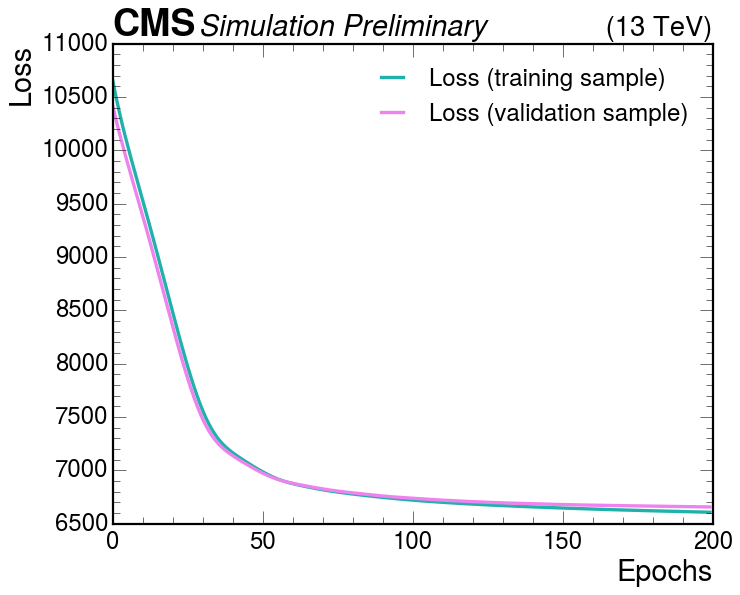

In [12]:
outdir = "Plots/"+approach

fig  = plt.figure(figsize=(10, 8))
ax= fig.add_axes([0.15, 0.15, 0.75, 0.75])
fig.patch.set_facecolor('white')
plt.rcParams["font.family"] = "serif"
plt.style.use('classic')
plt.style.use(hep.style.ROOT)
hep.cms.label("Preliminary", data=False)
plt.plot(hist.history['loss'], color = 'lightseagreen', linewidth=3, label='Loss (training sample)')
plt.plot(hist.history['val_loss'], color = 'violet', linewidth=3, label='Loss (validation sample)')
plt.xlabel("Epochs")
plt.ylabel("Loss")
#plt.yscale('log')
#plt.ylim(1, 10000000)
plt.legend()
#plt.show()
plt.savefig(outdir+"/loss_WeightedCrossEntropyLoss.png")


In [13]:
preds = tf.sigmoid(model.predict(training_data[:, :])).numpy()[:, 0]
#preds = model.predict(training_data)
preds.shape

66651/66651 [==============================] - 24s 362us/step


(2132802,)

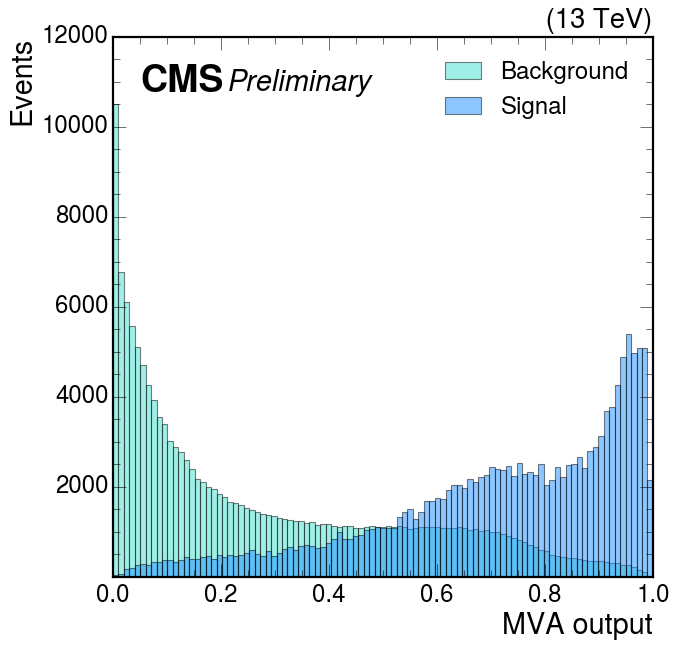

In [42]:
w = true_label[:, 0]
fig  = plt.figure(figsize=(9, 9))
fig.patch.set_facecolor('white')
ax= fig.add_axes([0.2, 0.15, 0.75, 0.75])
plt.style.use(hep.style.ROOT)
hep.cms.label("Preliminary", data=True, loc=1)
plt.hist(preds[true_label[:, -1]==0], weights = w[true_label[:, -1]==0], bins=np.linspace(0., 1., 100), color='turquoise', label='Background', alpha=0.5,)
plt.hist(preds[true_label[:, -1]==1], weights = w[true_label[:, -1]==1], bins=np.linspace(0., 1., 100), color='dodgerblue', label='Signal', alpha=0.5)
#plt.yscale('log')
#plt.ylim(1, 80000)  # Set y-axis limits
plt.ylim(1, 12000)  # Set y-axis limits
plt.xlabel("MVA output")
plt.ylabel("Events")

# Create an inset axis for the AUC plot
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#inset_ax = inset_axes(ax, width="90%", height="40%", loc='lower right', bbox_to_anchor=(0.15, 0.45, 0.75, 0.75), bbox_transform=ax.transAxes)

# Plotting the AUC graph in the inset
#mass_points = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]
#AUC_list = [0.823, 0.834, 0.823, 0.833, 0.84, 0.825, 0.83, 0.825, 0.824, 0.805, 0.797, 0.79, 0.788]
#inset_ax.plot(mass_points, AUC_list, marker='*', color='blue')
#inset_ax.set_xlabel(r'$m_{\gamma\gamma}$ [GeV]',fontsize=12)
#inset_ax.set_ylabel('AUC', fontsize=12)
#inset_ax.set_ylim(0.77, 0.86)
#inset_ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=4))  # Adjust number of ticks
#inset_ax.tick_params(axis='both', which='major', labelsize=14)


plt.legend()
#plt.savefig(outdir+"/mvaOutput_WeightedCrossEntropyLoss_nearestPoint.png", dpi=500)
#plt.savefig(outdir+"/mvaOutput_WeightedCrossEntropyLoss_nearestPoint.pdf", dpi=500)
plt.savefig(outdir+"/mvaOutput_WeightedCrossEntropyLoss_nearestPoint_noLog.png", dpi=1000)
plt.savefig(outdir+"/mvaOutput_WeightedCrossEntropyLoss_nearestPoint_noLog.pdf", dpi=1000)

In [ ]:
model.save_weights("models/model_WeightedCrossEntropyLoss_nearestPoint_newSamples_flat.h5")

In [ ]:
# --Plot ROC
# ----------

from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(true_label[:, -1]==1, preds)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
fig  = plt.figure(figsize=(9, 6))
fig.patch.set_facecolor('white')
ax= fig.add_axes([0.2, 0.15, 0.75, 0.75])
plt.style.use(hep.style.ROOT)
hep.cms.label("Preliminary", data=False)
plt.rcParams["font.family"] = "serif"
plt.style.use('classic')
plt.plot(fpr, tpr, color='orchid', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='purple', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
legend = plt.legend(loc="lower right", handlelength=0, fontsize='xx-large')
legend.set_frame_on(False) 
#plt.show()
plt.savefig(outdir + '/roc_curve_MLfunc.png')